# **HyperParameter Tuning using GA (using imbalanced dataset - CIFAR-10 )**

In [ ]:
from tensorflow.keras import datasets

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
# Normalise the dataset
x_train = x_train/255.
x_test = x_test/255.
# Flattening of the labels will be
# essential later
y_train = y_train.flatten()
y_test = y_test.flatten()
print('*'*40)
print("[INFO]: x_train shape: {}".format(x_train.shape))
print("[INFO]: y_train shape: {}".format(y_train.shape))
print('*'*40)
print("[INFO]: x_test shape: {}".format(x_test.shape))
print("[INFO]: y_test shape: {}".format(y_test.shape))

****************************************
[INFO]: x_train shape: (50000, 32, 32, 3)
[INFO]: y_train shape: (50000,)
****************************************
[INFO]: x_test shape: (10000, 32, 32, 3)
[INFO]: y_test shape: (10000,)


In [ ]:
SEED = 666
import numpy as np
np.random.seed(SEED)

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.utils import class_weight

import tensorflow as tf
tf.random.set_seed(SEED)
from tensorflow import keras
from tensorflow.keras.utils import to_categorical 

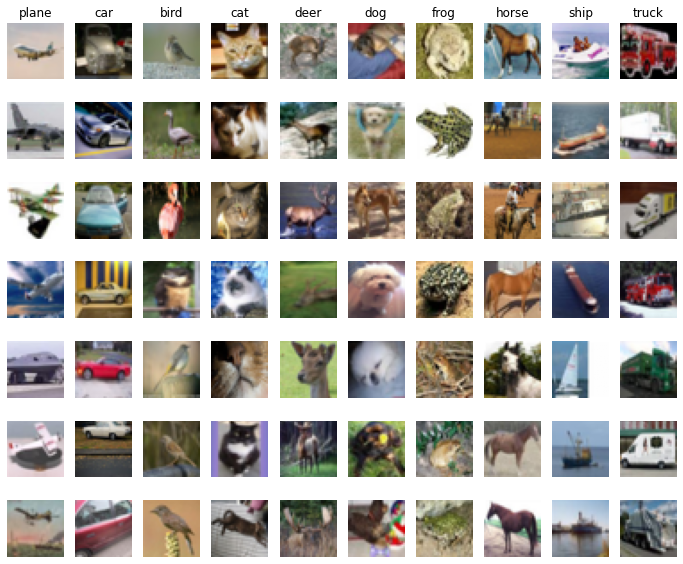

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)                      #10
samples_per_class = 7                           # 7 samples per class
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)         # got hold of all the indices
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# This dictionary is made for better code readability.
classes_dict = {
    'plane':0,
    'car':1
}

# To generate the indices of the data that we want. (Train)
idx_train = np.concatenate(
    (
     np.where(y_train == classes_dict['plane'])[0],
     np.where(y_train == classes_dict['car'])[0]
    )
)

x_train_bal = x_train[idx_train]
y_train_bal = y_train[idx_train]
y_train_bal = to_categorical(y_train_bal, num_classes=2)

# To generate the indices of the data that we want. (Test)
idx_test = np.concatenate(
    (
     np.where(y_test == classes_dict['plane'])[0],
     np.where(y_test == classes_dict['car'])[0]
    )
)

x_test_bal = x_test[idx_test]
y_test_bal = y_test[idx_test]
y_test_bal = to_categorical(y_test_bal, num_classes=2)

x_train_bal, y_train_bal = shuffle(x_train_bal, y_train_bal, random_state=SEED)
x_test_bal, y_test_bal = shuffle(x_test_bal, y_test_bal, random_state=SEED)

print("[INFO]: x_train_bal shape: {}".format(x_train_bal.shape))
print("[INFO]: y_train_bal shape: {}".format(y_train_bal.shape))
print("[INFO]: x_test_bal shape: {}".format(x_test_bal.shape))
print("[INFO]: y_test_bal shape: {}".format(y_test_bal.shape))

[INFO]: x_train_bal shape: (10000, 32, 32, 3)
[INFO]: y_train_bal shape: (10000, 2)
[INFO]: x_test_bal shape: (2000, 32, 32, 3)
[INFO]: y_test_bal shape: (2000, 2)


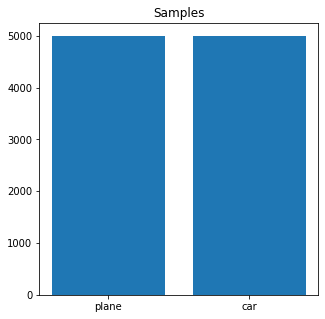

In [ ]:
class_labels, label_counts = np.unique(y_train_bal,axis=0,return_counts=True)

plt.figure(figsize=(5,5))
plt.bar([0,1], label_counts);
plt.xticks(
    range(2),
    ('plane',
     'car')
    )
plt.title('Samples')
plt.show()

In [ ]:
# To generate the indices of the data that we want. (Train)
idx_train = np.concatenate(
    (
     np.where(y_train == classes_dict['plane'])[0],
     np.where(y_train == classes_dict['car'])[0][:50]
    )
)

x_train_im = x_train[idx_train]
y_train_im = y_train[idx_train]
y_train_im = to_categorical(y_train_im, num_classes=2)

x_train_im, y_train_im = shuffle(x_train_im, y_train_im, random_state=SEED)

print("[INFO]: x_train_im shape: {}".format(x_train_im.shape))
print("[INFO]: y_train_im shape: {}".format(y_train_im.shape))

[INFO]: x_train_im shape: (5050, 32, 32, 3)
[INFO]: y_train_im shape: (5050, 2)


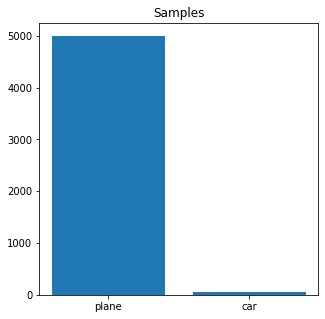

In [ ]:
class_labels, label_counts = np.unique(y_train_im, axis = 0, return_counts=True)

plt.figure(figsize=(5,5))
plt.bar([1,0], label_counts);
plt.xticks(
    range(2),
    ('plane',
     'car')
    )
plt.title('Samples')
plt.show()

In [ ]:
def make_dataloader(x_train,
                    y_train,
                    x_test,
                    y_test,
                    IMG_SHAPE,
                    BATCH_SIZE=32):
  '''
  args:
    x_train: The train samples
    y_train: The train lables
    x_test: The test samples
    y_test: The test labels
    BATCH_SIZE: The batch size
    IMG_SHAPE: The image shape of the input
  output:
    trainloader: tf.data pipeline for train
    testloader: tf.data pipeline for test
  '''
  AUTO = tf.data.experimental.AUTOTUNE

  trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

  trainloader = (
      trainloader
      .shuffle(1024)
      .batch(BATCH_SIZE)
      .prefetch(AUTO)
  )

  testloader = (
      testloader
      .batch(BATCH_SIZE)
      .prefetch(AUTO)
  )
  return (trainloader, testloader)

In [ ]:
BATCH_SIZE = 32
IMG_SHAPE = 32
trainloader, testloader = make_dataloader(x_train = x_train_im,
                                          y_train = y_train_im,
                                          x_test = x_test_bal,
                                          y_test = y_test_bal,
                                          BATCH_SIZE=BATCH_SIZE,
                                          IMG_SHAPE=IMG_SHAPE)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
cls_wt = class_weight.compute_class_weight(class_weight = "balanced",
                                           classes=np.unique(np.argmax(y_train_im, axis=1)), 
                                           y=np.argmax(y_train_im, axis=1))

In [ ]:
class_weights = {0: cls_wt[0], 1:cls_wt[1]}
class_weights, np.unique(y_train_im.flatten())

({0: 0.505, 1: 50.5}, array([0., 1.], dtype=float32))

In [ ]:
def CNN_model( f1, f2, f3, k, a1, a2, d1, d2, op, ep):
  model = models.Sequential()
  model.add(layers.Conv2D(filters = f1, kernel_size = (k, k), activation = a1, input_shape = (32,32,3)))
  model.add(layers.Conv2D(filters = f1, kernel_size = (k, k), activation = a1))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(filters = f2, kernel_size = (k, k), activation = a2))
  model.add(layers.Conv2D(filters = f2, kernel_size = (k, k), activation = a2))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Flatten())
  model.add(layers.Dropout(rate = d1))
  model.add(layers.Dense(units = f3, activation = a2))
  model.add(layers.Dropout(rate = d2))
  model.add(layers.Dense(2, activation= "softmax"))

  model.compile(loss = "categorical_crossentropy", optimizer = op, metrics = ["accuracy"])
  es = EarlyStopping(monitor="val_accuracy", patience = 7)
  # model.fit(partial_images, partial_labels, validation_data=(val_images,val_labels), epochs=ep, batch_size = 100, callbacks = [es], verbose=0)
  model.fit(trainloader,class_weight=class_weights,epochs=ep,validation_data=testloader,callbacks=[es])
  return model

In [ ]:
from random import choice
from random import uniform
from numpy.random import randint

In [ ]:
def initialization():  
  parameters = {}
  f1 = choice([32, 64])
  parameters["f1"] = f1
  f2 = choice([64, 128])
  parameters["f2"] = f2
  f3 = choice([128, 256, 512])
  parameters["f3"] = f3
  k = choice([3,5])
  parameters["k"] = k
  a1 = choice(["relu", "selu", "elu"])
  parameters["a1"] = a1
  a2 = choice(["relu", "selu", "elu"])
  parameters["a2"] = a2
  d1 = round(uniform(0.1, 0.5), 1)
  parameters["d1"] = d1
  d2 = round(uniform(0.1, 0.5), 1)
  parameters["d2"] = d2
  op = choice(["adamax", "adadelta", "adam", "adagrad"])
  parameters["op"] = op
  ep = randint(50, 100)
  parameters["ep"] = ep
  return parameters

In [ ]:
def generate_population(n):
  population = []
  for i in range(n):
    chromosome = initialization()
    population.append(chromosome)
  return population

In [ ]:
def fitness_evaluation(model):
  metrics = model.evaluate(x_test_bal,y_test_bal)
  return metrics[1]

In [ ]:
# Roulette wheel selection method
def selection(population_fitness):
  total = sum(population_fitness)
  print(total)
  percentage = [round((x/total) * 100) for x in population_fitness]
  selection_wheel = []
  for pop_index,num in enumerate(percentage):
    selection_wheel.extend([pop_index]*num)
  parent1_ind = choice(selection_wheel)
  parent2_ind = choice(selection_wheel)
  return [parent1_ind, parent2_ind]

In [ ]:
def crossover(parent1, parent2):
  child1 = {}
  child2 = {}

  child1["f1"] = choice([parent1["f1"], parent2["f1"]])
  child1["f2"] = choice([parent1["f2"], parent2["f2"]])
  child1["f3"] = choice([parent1["f3"], parent2["f3"]])

  child2["f1"] = choice([parent1["f1"], parent2["f1"]])
  child2["f2"] = choice([parent1["f2"], parent2["f2"]])
  child2["f3"] = choice([parent1["f3"], parent2["f3"]])

  child1["k"] = choice([parent1["k"], parent2["k"]])
  child2["k"] = choice([parent1["k"], parent2["k"]])

  child1["a1"] = parent1["a2"]
  child2["a1"] = parent2["a2"]

  child1["a2"] = parent2["a1"]
  child2["a2"] = parent1["a1"]

  child1["d1"] = parent1["d1"]
  child2["d1"] = parent2["d1"]

  child1["d2"] = parent2["d2"]
  child2["d2"] = parent1["d2"]

  child1["op"] = parent2["op"]
  child2["op"] = parent1["op"]

  child1["ep"] = parent1["ep"]
  child2["ep"] = parent2["ep"]
  return [child1, child2]

In [ ]:
def mutation(chromosome):
  flag = randint(0,40)
  if flag <= 20:
    chromosome["ep"] += randint(0, 10)
  return chromosome

In [ ]:
import traceback
generations = 10
threshold = 90
num_pop = 10

population = generate_population(num_pop)
print(population)
for generation in range(generations):

  population_fitness = []
  for chromosome in population:
    f1 = chromosome["f1"]
    f2 = chromosome["f2"]
    f3 = chromosome["f3"]
    k = chromosome["k"]
    a1 = chromosome["a1"]
    a2 = chromosome["a2"]
    d1 = chromosome["d1"]
    d2 = chromosome["d2"]
    op = chromosome["op"]
    ep = chromosome["ep"]

    try:
      model = CNN_model(f1, f2, f3, k, a1, a2, d1, d2, op, ep)
      acc = fitness_evaluation(model)
      print("Parameters: ", chromosome)
      print("Accuracy: ", round(acc,3))
    except:
      acc=0
      print("Parameters: ", chromosome)
      traceback.print_exc()
      print("Invalid parameters - Build fail")

    population_fitness.append(acc)
    
  print(population_fitness)
  parents_ind = selection(population_fitness)
  parent1 = population[parents_ind[0]]
  parent2 = population[parents_ind[1]]

  children = crossover(parent1, parent2)
  child1 = mutation(children[0])
  child2 = mutation(children[1])

  population.append(child1)
  population.append(child2)

  print("Generation ", generation+1," Outcome: ")
  if max(population_fitness) >= threshold:
    print("Obtained desired accuracy: ", max(population_fitness))
    break
  else:
    print("Maximum accuracy in generation {} : {}".format(generation+1, max(population_fitness)))

  first_min = min(population_fitness)
  first_min_ind = population_fitness.index(first_min)
  population.remove(population[first_min_ind])
  second_min = min(population_fitness)
  second_min_ind = population_fitness.index(second_min)
  population.remove(population[second_min_ind])

[{'f1': 32, 'f2': 64, 'f3': 128, 'k': 5, 'a1': 'elu', 'a2': 'elu', 'd1': 0.4, 'd2': 0.3, 'op': 'adagrad', 'ep': 77}, {'f1': 64, 'f2': 128, 'f3': 256, 'k': 5, 'a1': 'elu', 'a2': 'relu', 'd1': 0.1, 'd2': 0.4, 'op': 'adadelta', 'ep': 51}, {'f1': 32, 'f2': 64, 'f3': 128, 'k': 3, 'a1': 'selu', 'a2': 'selu', 'd1': 0.3, 'd2': 0.4, 'op': 'adam', 'ep': 54}, {'f1': 32, 'f2': 128, 'f3': 128, 'k': 3, 'a1': 'elu', 'a2': 'relu', 'd1': 0.3, 'd2': 0.1, 'op': 'adagrad', 'ep': 57}, {'f1': 64, 'f2': 128, 'f3': 256, 'k': 3, 'a1': 'selu', 'a2': 'relu', 'd1': 0.2, 'd2': 0.2, 'op': 'adamax', 'ep': 73}, {'f1': 64, 'f2': 64, 'f3': 128, 'k': 5, 'a1': 'relu', 'a2': 'selu', 'd1': 0.4, 'd2': 0.2, 'op': 'adam', 'ep': 95}, {'f1': 32, 'f2': 128, 'f3': 512, 'k': 5, 'a1': 'selu', 'a2': 'selu', 'd1': 0.3, 'd2': 0.2, 'op': 'adamax', 'ep': 93}, {'f1': 64, 'f2': 128, 'f3': 512, 'k': 3, 'a1': 'selu', 'a2': 'elu', 'd1': 0.2, 'd2': 0.2, 'op': 'adamax', 'ep': 73}, {'f1': 64, 'f2': 64, 'f3': 256, 'k': 5, 'a1': 'elu', 'a2': 'elu